# Rede Convolucional similar a LeNet aplicada no MNIST

Neste notebook iremos utilizar uma rede convolucional similar à rede LeNet para treinar e classificar o conjunto de dados do MNIST.

## Importando as bibliotecas

In [1]:
%matplotlib inline

import numpy as np
import sys,os
import matplotlib.pyplot as plt
from IPython import display
from collections import OrderedDict

# from torch
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import lr_scheduler

# from torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# from course libs
sys.path.append('../lib')
import pytorch_utils

In [2]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: True


## Leitura e normalização do dataset MNIST

In [3]:
dataset_dir = '/data/datasets/MNIST/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados serão normalizados)
data_transform = transforms.ToTensor()

# carrega o conjunto de treinamento e de teste
datasets = {
    'train': MNIST(dataset_dir, train=True, transform=data_transform),
    'val': MNIST(dataset_dir, train=False, transform=data_transform),
}

print('Amostras para treinamento:', len(datasets['train']))
print('Amostras para validação:', len(datasets['val']))

Amostras para treinamento: 60000
Amostras para validação: 10000


## Mostrando algumas imagens do conjunto de treinamento

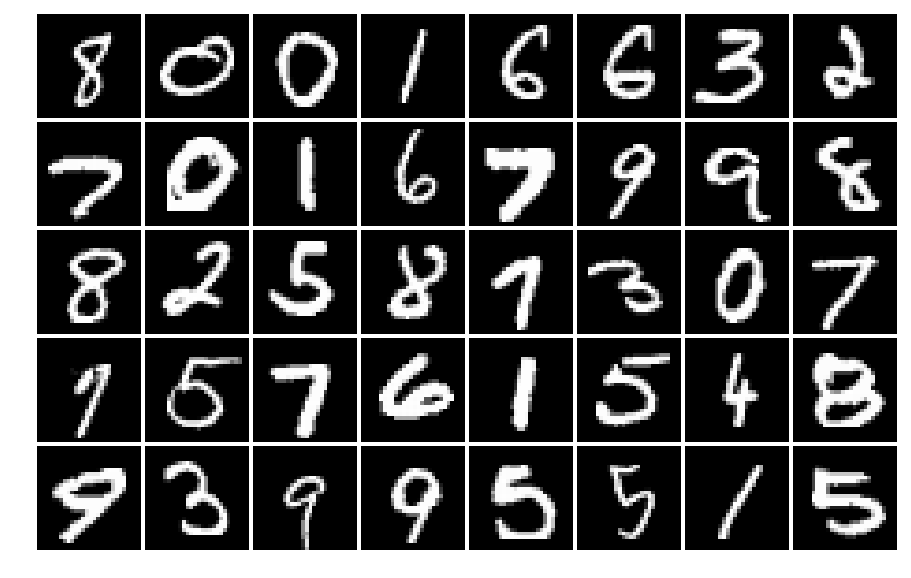

In [4]:
n_samples = 40

# cria um DataLoader temporario para pegar um batch de 'n_samples' imagens de treinamento
temp_dataloader = torch.utils.data.DataLoader(datasets['train'], 
                                              batch_size=n_samples,
                                              shuffle=True, num_workers=4)

# pega um batch de imagens
image_batch, labels = next(iter(temp_dataloader))

# cria um grid com as imagens
grid = torchvision.utils.make_grid(image_batch, normalize=True, pad_value=1.0, padding=1)

plt.figure(figsize=(20, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Pequena amostra, apenas para testar o código

In [5]:
if False:
    n_samples_train = 1000
    n_samples_test  = 500

    datasets['train'].train_data = datasets['train'].train_data[:n_samples_train]
    datasets['train'].train_labels = datasets['train'].train_labels[:n_samples_train]
    datasets['val'].test_data = datasets['val'].test_data[:n_samples_test]
    datasets['val'].test_labels = datasets['val'].test_labels[:n_samples_test]
    
    print('Amostras para treinamento:', len(datasets['train']))
    print('Amostras para validação:', len(datasets['val']))

## Cria o DataLoader para os dados

In [6]:
dataloders = {x: torch.utils.data.DataLoader(datasets[x], 
                                             batch_size=100,
                                             shuffle=True, num_workers=4)
                                             for x in ['train', 'val']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

print('Tamanho do conjunto de treinamento:', dataset_sizes['train'])
print('Tamanho do conjunto de validacao:', dataset_sizes['val'])

Tamanho do conjunto de treinamento: 60000
Tamanho do conjunto de validacao: 10000


## Criação do modelo da rede

<img src = '../../figures/Rede_LeNet_like.png', width=600pt></img>

In [7]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Camadas convolucionais
        self.conv_layer = nn.Sequential(OrderedDict([
            # lembrar de usar zero padding para manter o tamanho da imagem
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, padding=2)),   
            ('relu1', nn.ReLU()),
            ('max_pool1', nn.MaxPool2d(2)),

            ('conv2', nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, padding=2)),
            ('relu2', nn.ReLU()),
            ('max_pool2', nn.MaxPool2d(2)),
            
            ('drop', nn.Dropout(p=0.5))
        ]))
        
        # Camadas densas
        self.dense_layer = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(in_features=2450, out_features=50)),
            ('relu1', nn.ReLU()),
            ('dense2', nn.Linear(in_features=50, out_features=10)),
        ]))
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(-1, 2450)  # Transforma a matriz em vetor
        x = self.dense_layer(x)
        
        return x

## Como encontrar o tamanho correto para entrada da camada densa?

Para encontrar o tamanho da camada densa, criamos uma `Variable` de input com zeros e as mesmas dimensões da imagem de entrada, então a passamos pela camada convolucional. Verificamos a dimensão da saída e o tamanho do vetor após passar por uma vetorização. Este tamanho é o tamanho que deveremos utilizar na entrada da camada densa.

In [8]:
model = MyModel()

# input do mesmo tamanho que as imagens usadas
example_input = Variable(torch.zeros(1, 1, 28, 28))

# output da camada convolucional
example_output = model.conv_layer(example_input)

print('Dimensões da saída convolucional:', example_output.size())
print('Dimensão após a vetorização:', example_output.view(1, -1).size())

Dimensões da saída convolucional: torch.Size([1, 50, 7, 7])
Dimensão após a vetorização: torch.Size([1, 2450])


## Treinamento da rede

In [9]:
model = MyModel()
if use_gpu:
    model = model.cuda()
    
# Calcula o erro pela CrossEntropy
criterion = nn.CrossEntropyLoss()

# Otimizador
optimizer = torch.optim.Adam(model.parameters())

# Define a acurácia para ser calculada no treinamento
def accuracy(out, y):
    _, y_hat = torch.max(out, 1)
    return torch.sum(y_hat==y) / y_hat.size(0)

metrics = {'acc': accuracy}

trainer = pytorch_utils.DeepNetTrainer(
    file_basename='../../../models/lenet_1', 
    model=model, 
    criterion=criterion, 
    optimizer=optimizer,
    # Diminui o valor de lr por um fator de 0.1 a cada 7 epocas
    lr_scheduler=lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
    metrics=metrics,
    reset=True
)

In [10]:
trainer.fit(n_epochs=50, train_data=dataloders['train'], valid_data=dataloders['val'])

Starting training for 50 epochs
  1:   3.0s  T:    0.26044  0.92  V:    0.05974  0.98 best
  2:   2.6s  T:    0.08007  0.97  V:    0.04409  0.99 best
  3:   2.4s  T:    0.05920  0.98  V:    0.03918  0.99 best
  4:   2.4s  T:    0.04942  0.98  V:    0.02656  0.99 best
  5:   2.3s  T:    0.04226  0.99  V:    0.02541  0.99 best
  6:   2.4s  T:    0.03619  0.99  V:    0.02514  0.99 best
  7:   2.4s  T:    0.02485  0.99  V:    0.02007  0.99 best
  8:   2.5s  T:    0.02321  0.99  V:    0.01996  0.99 best
  9:   2.4s  T:    0.02149  0.99  V:    0.02018  0.99 
 10:   2.4s  T:    0.02110  0.99  V:    0.01919  0.99 best
 11:   2.5s  T:    0.02000  0.99  V:    0.01824  0.99 best
 12:   2.4s  T:    0.01919  0.99  V:    0.01884  0.99 
 13:   2.4s  T:    0.01863  0.99  V:    0.01857  0.99 
 14:   2.4s  T:    0.01762  0.99  V:    0.01813  0.99 best
 15:   2.4s  T:    0.01789  0.99  V:    0.01817  0.99 
 16:   2.3s  T:    0.01609  0.99  V:    0.01826  0.99 
 17:   2.3s  T:    0.01696  0.99  V:    0.01

## Avaliação do treinamento no conjunto de testes

In [11]:
# testa a rede e pega as classes e probabilidades de saída
y_hat, y_prob = pytorch_utils.test_network(model, datasets['val'], criterion)


Accuracy on the test data set: 99.36% [0.01803]


In [12]:
X_test = datasets['val'].test_data.numpy()
y_test = datasets['val'].test_labels.numpy()
print('Rótulos conj. teste:',y_test[:10])
print('Rótulos previstos:  ',y_hat[:10])

Rótulos conj. teste: [7 2 1 0 4 1 4 9 5 9]
Rótulos previstos:   [7 2 1 0 4 1 4 9 5 9]


## Predições certas com maior probabilidade

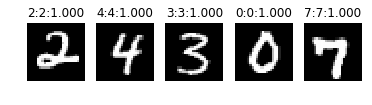

In [13]:
i_ok = np.where(y_hat==y_test)[0]
top_most_ok = np.argsort(y_prob[i_ok])[-5:][::-1]
y_top5 = i_ok[top_most_ok]
for k,i in enumerate(y_top5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i],cmap='gray')
    plt.title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Predições certas com menor probabilidade

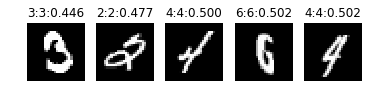

In [14]:
i_ok = np.where(y_hat==y_test)[0]
top_least_ok = np.argsort(y_prob[i_ok])[:5]
y_bot5 = i_ok[top_least_ok]
for k,i in enumerate(y_bot5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i],cmap='gray')
    plt.title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Predições erradas com maior probabilidade

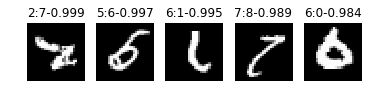

In [15]:
i_not_ok = np.where(y_hat!=y_test)[0]
top_most_not_ok = np.argsort(y_prob[i_not_ok])[-5:][::-1]
y_most_not_ok_top5 = i_not_ok[top_most_not_ok]

for k,i in enumerate(y_most_not_ok_top5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i],cmap='gray')
    plt.title('{}:{}-{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Predições erradas com menor probabilidade

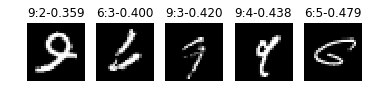

In [16]:
i_not_ok = np.where(y_hat!=y_test)[0]
top_least_not_ok = np.argsort(y_prob[i_not_ok])[:5]
y_least_not_ok_top5 = i_not_ok[top_least_not_ok]

for k,i in enumerate(y_least_not_ok_top5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i],cmap='gray')
    plt.title('{}:{}-{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Atividades

1. Calcular o número de parâmetros a serem treinados nesta rede e verificar se confere com o sumário da rede
2. Mostrar a matriz de confusão da rede aplicada no conjunto de testes


## Aprendizados com este notebook
